# 📊 MNIST 데이터셋 분석 (PyTorch)

이 노트북에서는 PyTorch를 사용하여 MNIST 데이터셋에 대한 전체 분석 파이프라인을 구축합니다.

## 목차
1. 라이브러리 임포트
2. 데이터 로드
3. 탐색적 데이터 분석 (EDA)
4. 시각화
5. 데이터 전처리
6. 모델 정의
7. 모델 학습
8. 모델 평가
9. 결과 분석

## 1. 라이브러리 임포트

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 재현성을 위한 시드 설정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch 버전: {torch.__version__}')
print(f'사용 디바이스: {device}')

PyTorch 버전: 2.5.1
사용 디바이스: cuda


## 2. 데이터 로드

In [ ]:
# 기본 변환 없이 원본 데이터 로드 (EDA용)
raw_train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

raw_test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)




Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

훈련 데이터셋 크기: 60000
테스트 데이터셋 크기: 10000
데이터셋 클래스: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

이미지 shape: torch.Size([1, 28, 28])  (C x H x W)
레이블: 5
픽셀 값 범위: [0.0000, 1.0000]


In [16]:
print(f'훈련 데이터셋 크기: {len(raw_train_dataset)}')
print(f'테스트 데이터셋 크기: {len(raw_test_dataset)}')
print(f'데이터셋 클래스: {raw_train_dataset.classes}')


훈련 데이터셋 크기: 60000
테스트 데이터셋 크기: 10000
데이터셋 클래스: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [15]:
# 단일 샘플 확인
sample_image, sample_label = raw_train_dataset[0]
print(f'\n이미지 shape: {sample_image.shape}  (C x H x W)')
print(f'레이블: {sample_label}')
print(f'픽셀 값 범위: [{sample_image.min():.4f}, {sample_image.max():.4f}]')


이미지 shape: torch.Size([1, 28, 28])  (C x H x W)
레이블: 5
픽셀 값 범위: [0.0000, 1.0000]


## 3. 탐색적 데이터 분석 (EDA)

In [3]:
# 훈련 데이터 레이블 추출
train_labels = raw_train_dataset.targets.numpy()
test_labels  = raw_test_dataset.targets.numpy()

print('=== 훈련 데이터 통계 ===')
print(f'총 샘플 수   : {len(train_labels):,}')
print(f'클래스 수    : {len(np.unique(train_labels))}')
print(f'레이블 유니크값: {np.unique(train_labels)}')

print('\n=== 클래스별 샘플 분포 ===')
unique, counts = np.unique(train_labels, return_counts=True)
for label, count in zip(unique, counts):
    bar = '█' * (count // 200)
    print(f'  숫자 {label}: {count:,}개  |{bar}')

=== 훈련 데이터 통계 ===
총 샘플 수   : 60,000
클래스 수    : 10
레이블 유니크값: [0 1 2 3 4 5 6 7 8 9]

=== 클래스별 샘플 분포 ===
  숫자 0: 5,923개  |█████████████████████████████
  숫자 1: 6,742개  |█████████████████████████████████
  숫자 2: 5,958개  |█████████████████████████████
  숫자 3: 6,131개  |██████████████████████████████
  숫자 4: 5,842개  |█████████████████████████████
  숫자 5: 5,421개  |███████████████████████████
  숫자 6: 5,918개  |█████████████████████████████
  숫자 7: 6,265개  |███████████████████████████████
  숫자 8: 5,851개  |█████████████████████████████
  숫자 9: 5,949개  |█████████████████████████████


In [ ]:
# 데이터 형태 및 메모리 정보
# raw_train_dataset: torch.Tensor 타입
# raw_train_dataset.data.float(): numpy array 타입
all_images = raw_train_dataset.data.float() / 255.0  # numpy array

print('=== 데이터셋 형태 ===')
print(f'훈련 이미지 shape: {raw_train_dataset.data.shape}')
print(f'테스트 이미지 shape: {raw_test_dataset.data.shape}')

print('\n=== 픽셀 통계 (정규화 전) ===')
raw_data = raw_train_dataset.data.float()
print(f'평균  : {raw_data.mean():.4f}')
print(f'표준편차: {raw_data.std():.4f}')
print(f'최솟값: {raw_data.min():.4f}')
print(f'최댓값: {raw_data.max():.4f}')

print('\n=== 정규화 후 (÷255) ===')
print(f'평균  : {all_images.mean():.4f}')
print(f'표준편차: {all_images.std():.4f}')

=== 데이터셋 형태 ===
훈련 이미지 shape: torch.Size([60000, 28, 28])
테스트 이미지 shape: torch.Size([10000, 28, 28])

=== 픽셀 통계 (정규화 전) ===
평균  : 33.3184
표준편차: 78.5675
최솟값: 0.0000
최댓값: 255.0000

=== 정규화 후 (÷255) ===
평균  : 0.1307
표준편차: 0.3081


## 4. 시각화

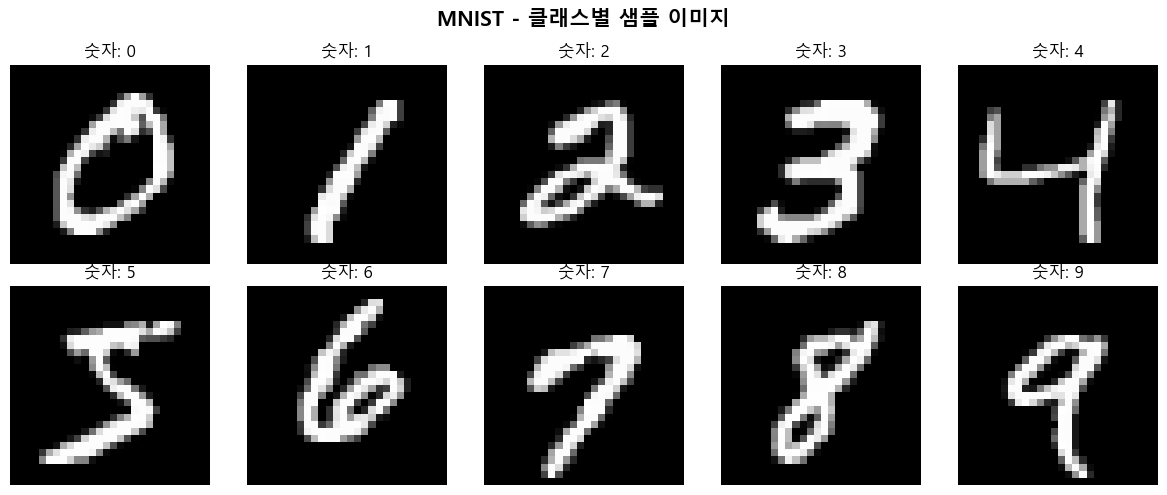

In [5]:
# 4.1 클래스별 샘플 이미지 시각화
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('MNIST - 클래스별 샘플 이미지', fontsize=15, fontweight='bold')

for digit in range(10):
    idx = (raw_train_dataset.targets == digit).nonzero(as_tuple=True)[0][0]
    img = raw_train_dataset.data[idx].numpy()
    ax = axes[digit // 5][digit % 5]
    ax.imshow(img, cmap='gray')
    ax.set_title(f'숫자: {digit}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

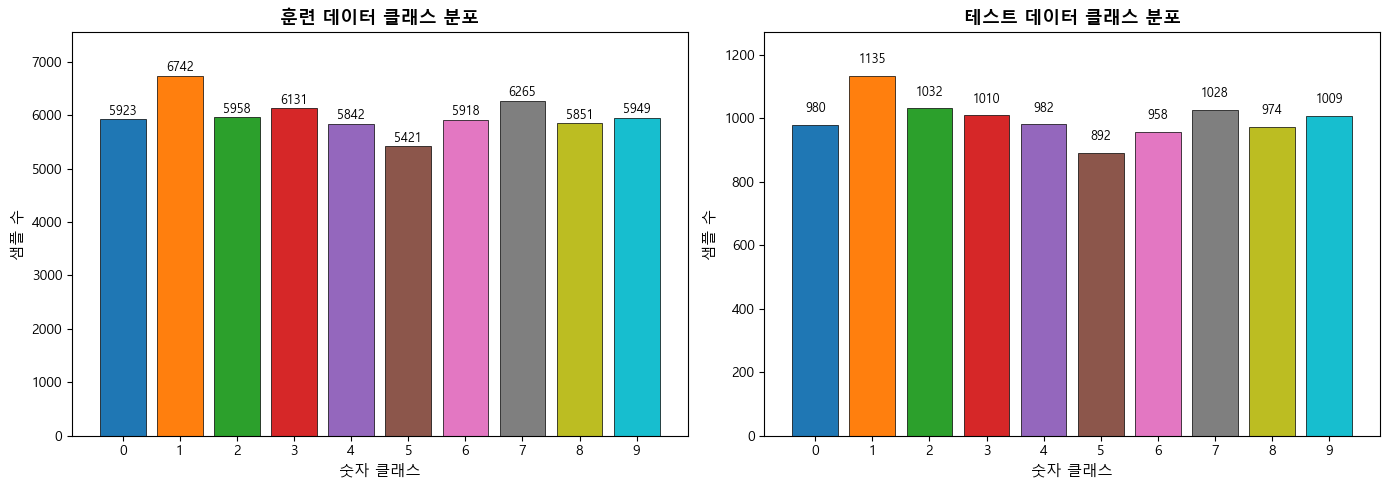

In [6]:
# 4.2 클래스 분포 막대 그래프
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, labels, title in zip(
    axes,
    [train_labels, test_labels],
    ['훈련 데이터 클래스 분포', '테스트 데이터 클래스 분포']
):
    unique, counts = np.unique(labels, return_counts=True)
    bars = ax.bar(unique, counts, color=plt.cm.tab10(unique / 10), edgecolor='black', linewidth=0.5)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel('숫자 클래스', fontsize=11)
    ax.set_ylabel('샘플 수', fontsize=11)
    ax.set_xticks(unique)
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
                str(count), ha='center', va='bottom', fontsize=9)
    ax.set_ylim(0, max(counts) * 1.12)

plt.tight_layout()
plt.show()

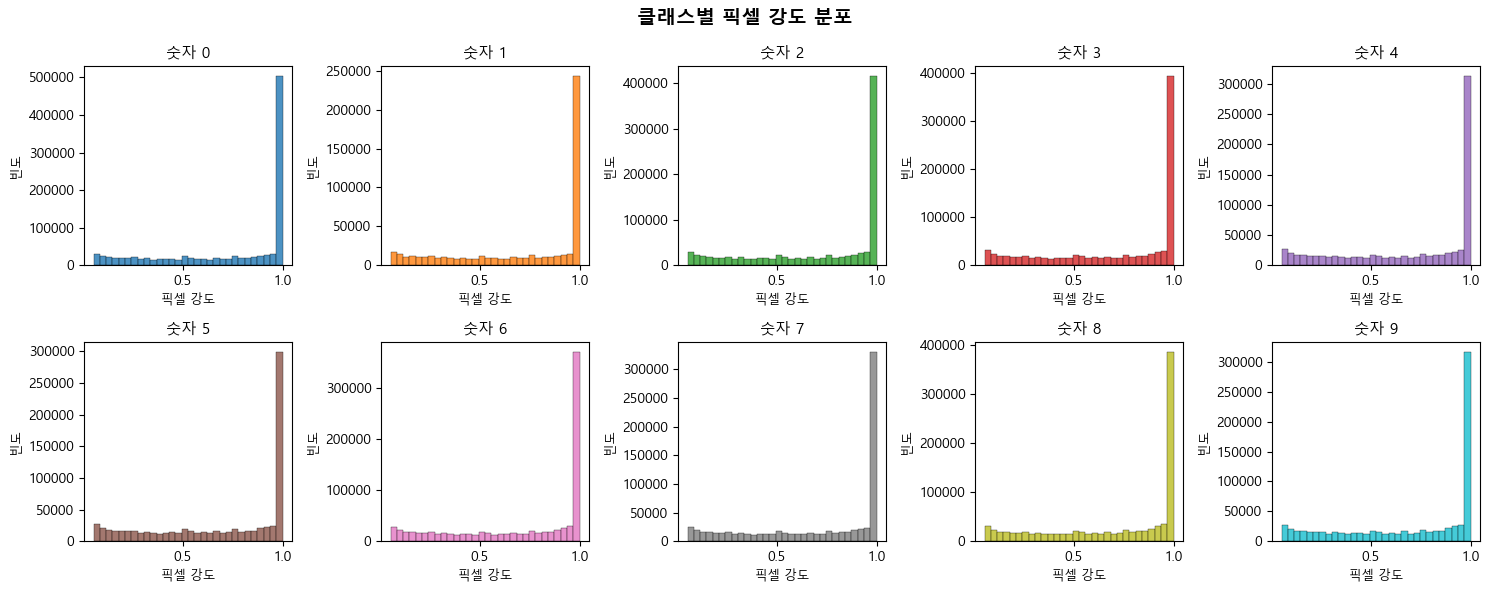

In [7]:
# 4.3 픽셀 강도 분포 히스토그램
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('클래스별 픽셀 강도 분포', fontsize=14, fontweight='bold')

for digit in range(10):
    mask = raw_train_dataset.targets == digit
    pixel_vals = raw_train_dataset.data[mask].float().numpy().flatten() / 255.0
    # 배경(0값) 제외
    nonzero_pixels = pixel_vals[pixel_vals > 0.05]
    ax = axes[digit // 5][digit % 5]
    ax.hist(nonzero_pixels, bins=30, color=plt.cm.tab10(digit / 10), alpha=0.8, edgecolor='black', linewidth=0.3)
    ax.set_title(f'숫자 {digit}', fontsize=11)
    ax.set_xlabel('픽셀 강도', fontsize=9)
    ax.set_ylabel('빈도', fontsize=9)

plt.tight_layout()
plt.show()

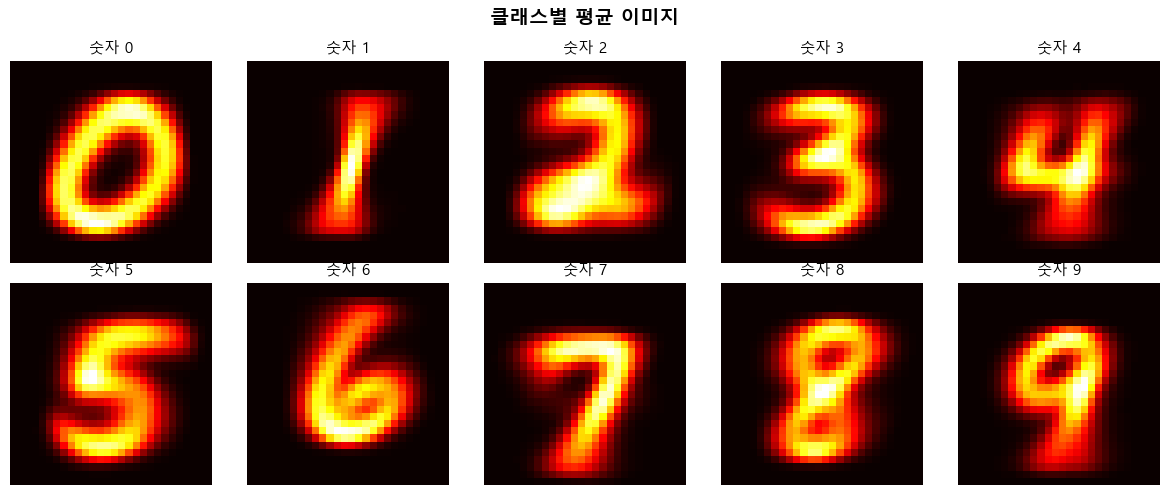

In [8]:
# 4.4 클래스별 평균 이미지
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('클래스별 평균 이미지', fontsize=14, fontweight='bold')

for digit in range(10):
    mask = raw_train_dataset.targets == digit
    mean_img = raw_train_dataset.data[mask].float().mean(dim=0).numpy()
    ax = axes[digit // 5][digit % 5]
    im = ax.imshow(mean_img, cmap='hot')
    ax.set_title(f'숫자 {digit}', fontsize=11)
    ax.axis('off')

plt.tight_layout()
plt.show()

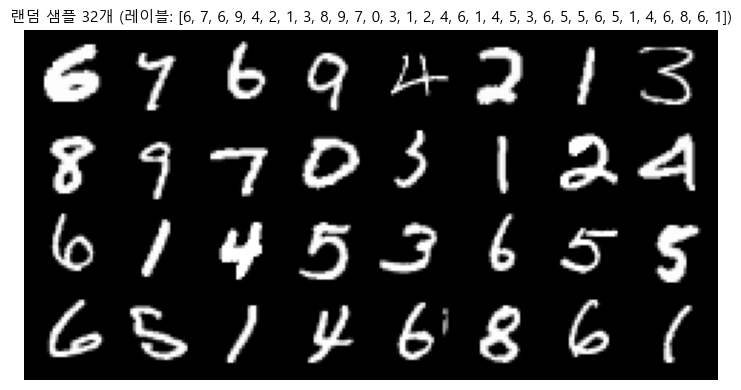

In [9]:
# 4.5 랜덤 샘플 그리드
indices = torch.randperm(len(raw_train_dataset))[:32]
images = torch.stack([raw_train_dataset[i][0] for i in indices])
labels_sample = [raw_train_dataset[i][1] for i in indices]

grid = make_grid(images, nrow=8, padding=2)
plt.figure(figsize=(14, 4))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.title(f'랜덤 샘플 32개 (레이블: {labels_sample})', fontsize=11)
plt.axis('off')
plt.tight_layout()
plt.show()

## 5. 데이터 전처리

In [ ]:
# MNIST 데이터셋 전체 평균/표준편차 계산
temp_loader = DataLoader(raw_train_dataset, batch_size=60000)
# next(iter()) -> 이미지를 한장씩 가져와서 평군값과 표준편차를 계산
all_imgs, _ = next(iter(temp_loader))
mnist_mean = all_imgs.mean().item()
mnist_std  = all_imgs.std().item()
print(f'MNIST 평균: {mnist_mean:.4f}')
print(f'MNIST 표준편차: {mnist_std:.4f}')

MNIST 평균: 0.1307
MNIST 표준편차: 0.3081


In [ ]:
# 전처리 파이프라인 정의
# 훈련용: 데이터 증강 + 정규화
train_transform = transforms.Compose([
    # data augmentation
    transforms.RandomRotation(10),          # 랜덤 회전 (-10° ~ 10°)
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # 랜덤 이동
    transforms.ToTensor(),
    transforms.Normalize((mnist_mean,), (mnist_std,))  # 표준화
])

# 검증/테스트용: 정규화만
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mnist_mean,), (mnist_std,))
])

# 전처리 적용된 데이터셋 로드
full_train_dataset = datasets.MNIST(root='./data', train=True,  download=True, transform=train_transform)
test_dataset       = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

# 훈련 / 검증 분할 (80% / 20%)
train_size = int(0.8 * len(full_train_dataset))
val_size   = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

# DataLoader 생성
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f'훈련 샘플 수  : {len(train_dataset):,}')
print(f'검증 샘플 수  : {len(val_dataset):,}')
print(f'테스트 샘플 수: {len(test_dataset):,}')
print(f'배치 크기     : {BATCH_SIZE}')
print(f'훈련 배치 수  : {len(train_loader)}')

훈련 샘플 수  : 48,000
검증 샘플 수  : 12,000
테스트 샘플 수: 10,000
배치 크기     : 128
훈련 배치 수  : 375


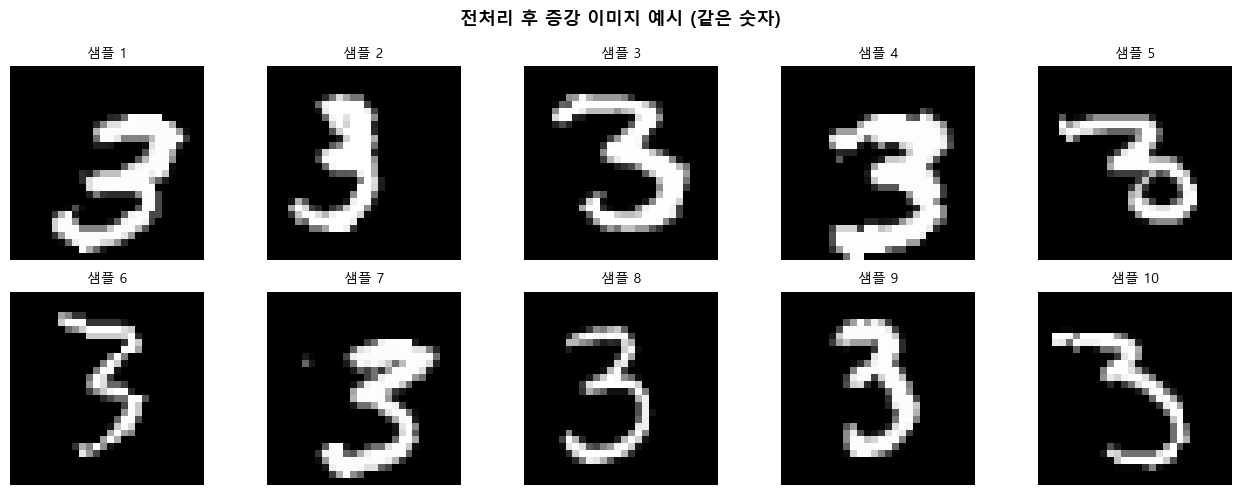

In [12]:
# 전처리 전후 비교 시각화
fig, axes = plt.subplots(2, 5, figsize=(13, 5))
fig.suptitle('전처리 후 증강 이미지 예시 (같은 숫자)', fontsize=13, fontweight='bold')

# 숫자 '3'에 대한 다양한 증강 결과
idx_3 = (raw_train_dataset.targets == 3).nonzero(as_tuple=True)[0][:10]
for i, idx in enumerate(idx_3):
    img_aug, _ = full_train_dataset[idx.item()]
    row, col = divmod(i, 5)
    axes[row][col].imshow(img_aug.squeeze().numpy(), cmap='gray')
    axes[row][col].set_title(f'샘플 {i+1}', fontsize=10)
    axes[row][col].axis('off')

plt.tight_layout()
plt.show()

## 6. 모델 정의

두 가지 모델을 비교합니다:
- **MLP (Multi-Layer Perceptron)**: 완전연결 신경망
- **CNN (Convolutional Neural Network)**: 합성곱 신경망

In [13]:
# 6.1 MLP 모델
class MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[512, 256, 128], num_classes=10, dropout=0.3):
        super(MLP, self).__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers += [
                nn.Linear(in_dim, h),
                nn.BatchNorm1d(h),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout)
            ]
            in_dim = h
        layers.append(nn.Linear(in_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.net(x)


# 6.2 CNN 모델
class CNN(nn.Module):
    def __init__(self, num_classes=10, dropout=0.4):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            # 블록 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                             # 28x28 -> 14x14
            nn.Dropout2d(0.25),

            # 블록 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 14x14 -> 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                             # 14x14 -> 7x7
            nn.Dropout2d(0.25),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


# 모델 요약
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

mlp_model = MLP().to(device)
cnn_model = CNN().to(device)

print(f'MLP 파라미터 수: {count_params(mlp_model):,}')
print(f'CNN 파라미터 수: {count_params(cnn_model):,}')
print(f'\nMLP 구조:')
print(mlp_model)
print(f'\nCNN 구조:')
print(cnn_model)

MLP 파라미터 수: 569,226
CNN 파라미터 수: 871,530

MLP 구조:
MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
)

CNN 구조:
CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

## 7. 모델 학습

In [18]:
# 학습 및 평가 함수 정의
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss    += loss.item() * images.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total         += images.size(0)
    return total_loss / total, total_correct / total


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss    += loss.item() * images.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()
            total         += images.size(0)
    return total_loss / total, total_correct / total


def train_model(model, train_loader, val_loader, model_name, num_epochs=15, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0

    print(f'\n{"="*55}')
    print(f'  {model_name} 학습 시작 (epochs={num_epochs}, lr={lr})')
    print(f'{"="*55}')
    print(f'  Epoch | Train Loss | Val Loss | Train Acc | Val Acc')
    print(f'  {"-"*50}')

    for epoch in range(1, num_epochs + 1):
        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer)
        vl_loss, vl_acc = evaluate(model, val_loader, criterion)
        scheduler.step()

        history['train_loss'].append(tr_loss)
        history['val_loss'].append(vl_loss)
        history['train_acc'].append(tr_acc)
        history['val_acc'].append(vl_acc)

        if vl_acc > best_val_acc:
            best_val_acc = vl_acc
            torch.save(model.state_dict(), f'best_{model_name.lower()}.pth')

        print(f'  {epoch:5d} | {tr_loss:10.4f} | {vl_loss:8.4f} | {tr_acc:9.4f} | {vl_acc:7.4f}')

    print(f'  {"="*50}')
    print(f'  최고 검증 정확도: {best_val_acc:.4f}')
    return history

print('학습 함수 정의 완료!')

학습 함수 정의 완료!


In [19]:
# MLP 학습
mlp_history = train_model(mlp_model, train_loader, val_loader, 'MLP', num_epochs=15)


  MLP 학습 시작 (epochs=15, lr=0.001)
  Epoch | Train Loss | Val Loss | Train Acc | Val Acc
  --------------------------------------------------
      1 |     0.6564 |   0.2474 |    0.7979 |  0.9254
      2 |     0.3380 |   0.1921 |    0.8942 |  0.9392
      3 |     0.2783 |   0.1642 |    0.9135 |  0.9490
      4 |     0.2487 |   0.1449 |    0.9219 |  0.9540
      5 |     0.2276 |   0.1328 |    0.9301 |  0.9579
      6 |     0.1920 |   0.1141 |    0.9404 |  0.9637
      7 |     0.1790 |   0.1050 |    0.9453 |  0.9677
      8 |     0.1739 |   0.0969 |    0.9453 |  0.9692
      9 |     0.1702 |   0.1014 |    0.9477 |  0.9682
     10 |     0.1610 |   0.0965 |    0.9499 |  0.9713
     11 |     0.1529 |   0.0878 |    0.9524 |  0.9738
     12 |     0.1435 |   0.0846 |    0.9550 |  0.9731
     13 |     0.1407 |   0.0820 |    0.9566 |  0.9738
     14 |     0.1396 |   0.0889 |    0.9566 |  0.9727
     15 |     0.1338 |   0.0820 |    0.9590 |  0.9729
  최고 검증 정확도: 0.9738


In [20]:
# CNN 학습
cnn_history = train_model(cnn_model, train_loader, val_loader, 'CNN', num_epochs=15)


  CNN 학습 시작 (epochs=15, lr=0.001)
  Epoch | Train Loss | Val Loss | Train Acc | Val Acc
  --------------------------------------------------
      1 |     0.3061 |   0.0943 |    0.9129 |  0.9700
      2 |     0.1060 |   0.0564 |    0.9687 |  0.9825
      3 |     0.0859 |   0.0453 |    0.9747 |  0.9858
      4 |     0.0734 |   0.0399 |    0.9776 |  0.9879
      5 |     0.0641 |   0.0383 |    0.9801 |  0.9875
      6 |     0.0533 |   0.0299 |    0.9839 |  0.9914
      7 |     0.0466 |   0.0293 |    0.9857 |  0.9908
      8 |     0.0474 |   0.0295 |    0.9856 |  0.9907
      9 |     0.0448 |   0.0258 |    0.9859 |  0.9918
     10 |     0.0446 |   0.0280 |    0.9862 |  0.9905
     11 |     0.0361 |   0.0249 |    0.9886 |  0.9918
     12 |     0.0380 |   0.0234 |    0.9883 |  0.9922
     13 |     0.0356 |   0.0246 |    0.9889 |  0.9922
     14 |     0.0346 |   0.0220 |    0.9896 |  0.9930
     15 |     0.0337 |   0.0236 |    0.9899 |  0.9924
  최고 검증 정확도: 0.9930


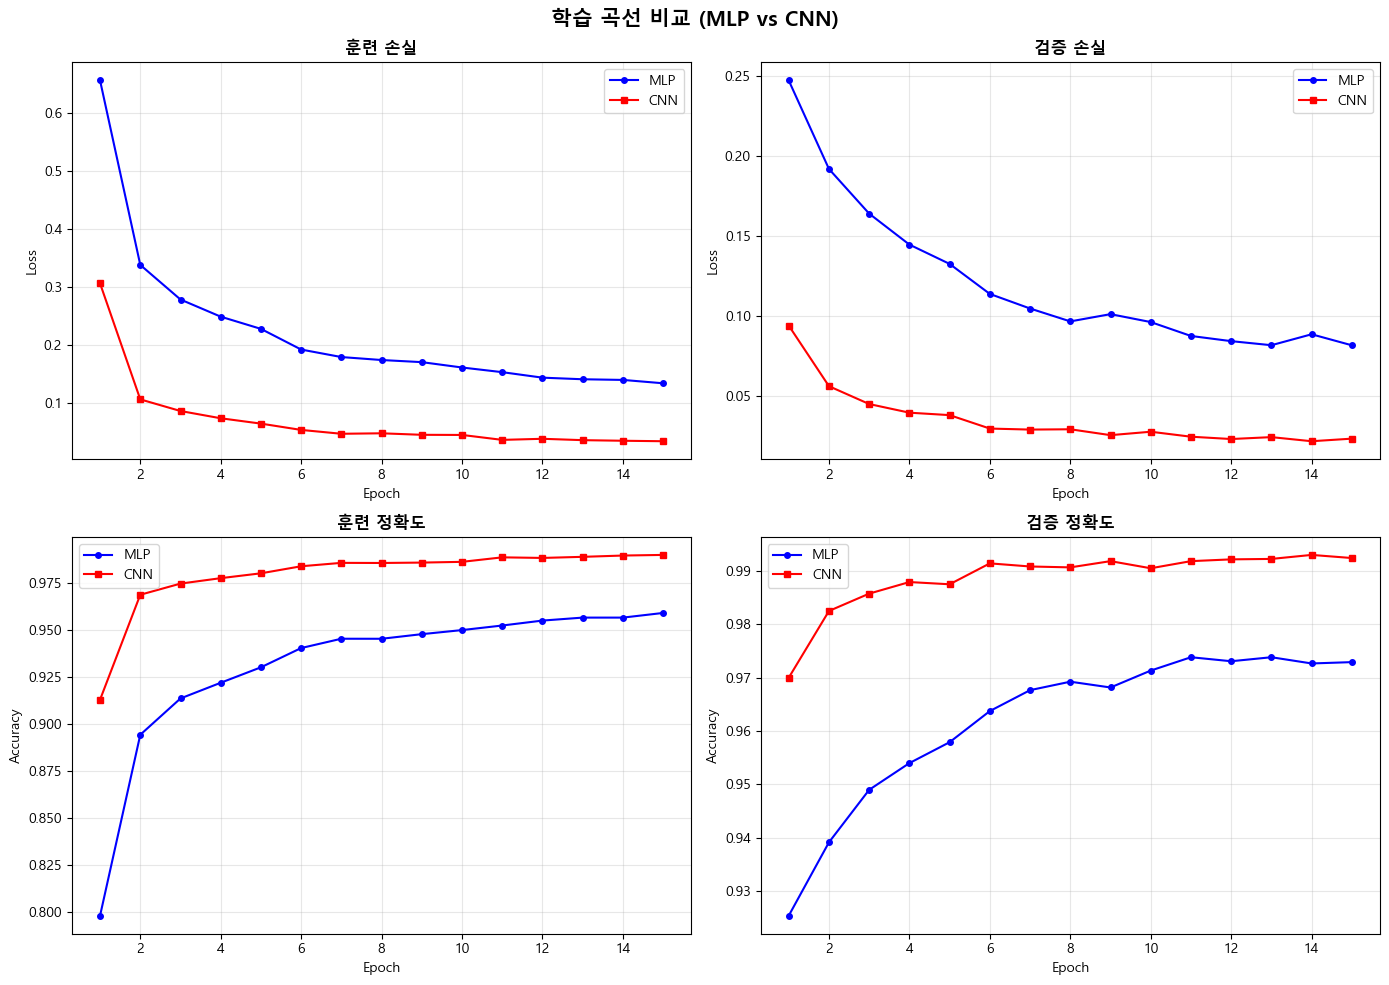

In [21]:
# 학습 곡선 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('학습 곡선 비교 (MLP vs CNN)', fontsize=15, fontweight='bold')

epochs = range(1, 16)
plot_configs = [
    ('train_loss', '훈련 손실', 'Loss'),
    ('val_loss',   '검증 손실', 'Loss'),
    ('train_acc',  '훈련 정확도', 'Accuracy'),
    ('val_acc',    '검증 정확도', 'Accuracy'),
]

for ax, (key, title, ylabel) in zip(axes.flatten(), plot_configs):
    ax.plot(epochs, mlp_history[key], 'b-o', markersize=4, label='MLP')
    ax.plot(epochs, cnn_history[key], 'r-s', markersize=4, label='CNN')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 모델 평가

In [22]:
# 최적 모델 가중치 로드 후 테스트셋 평가
def get_predictions(model, loader):
    model.eval()
    all_preds, all_targets, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs   = F.softmax(outputs, dim=1)
            preds   = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    return np.array(all_preds), np.array(all_targets), np.array(all_probs)


# 최적 가중치 로드
mlp_model.load_state_dict(torch.load('best_mlp.pth', map_location=device))
cnn_model.load_state_dict(torch.load('best_cnn.pth', map_location=device))

# 예측
mlp_preds, mlp_targets, mlp_probs = get_predictions(mlp_model, test_loader)
cnn_preds, cnn_targets, cnn_probs = get_predictions(cnn_model, test_loader)

# 정확도 계산
mlp_acc = (mlp_preds == mlp_targets).mean()
cnn_acc = (cnn_preds == cnn_targets).mean()

print(f'테스트 정확도')
print(f'  MLP: {mlp_acc:.4f} ({mlp_acc*100:.2f}%)')
print(f'  CNN: {cnn_acc:.4f} ({cnn_acc*100:.2f}%)')

테스트 정확도
  MLP: 0.9858 (98.58%)
  CNN: 0.9968 (99.68%)


In [23]:
# 8.1 분류 리포트
class_names = [str(i) for i in range(10)]

print('=== MLP 분류 리포트 ===')
print(classification_report(mlp_targets, mlp_preds, target_names=class_names))

print('=== CNN 분류 리포트 ===')
print(classification_report(cnn_targets, cnn_preds, target_names=class_names))

=== MLP 분류 리포트 ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

=== CNN 분류 리포트 ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1

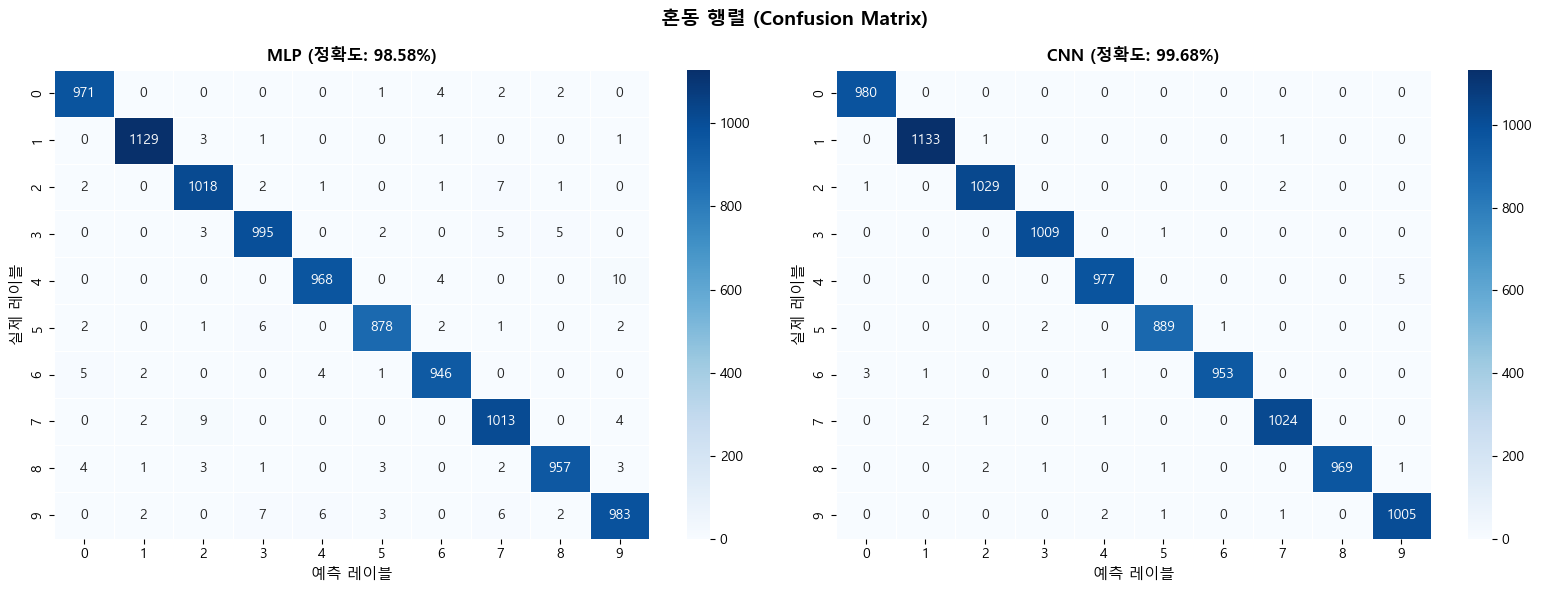

In [24]:
# 8.2 혼동 행렬 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('혼동 행렬 (Confusion Matrix)', fontsize=14, fontweight='bold')

for ax, preds, targets, title in zip(
    axes,
    [mlp_preds, cnn_preds],
    [mlp_targets, cnn_targets],
    [f'MLP (정확도: {mlp_acc*100:.2f}%)', f'CNN (정확도: {cnn_acc*100:.2f}%)']
):
    cm = confusion_matrix(targets, preds)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names, ax=ax,
        linewidths=0.5, cbar=True
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('예측 레이블', fontsize=11)
    ax.set_ylabel('실제 레이블', fontsize=11)

plt.tight_layout()
plt.show()

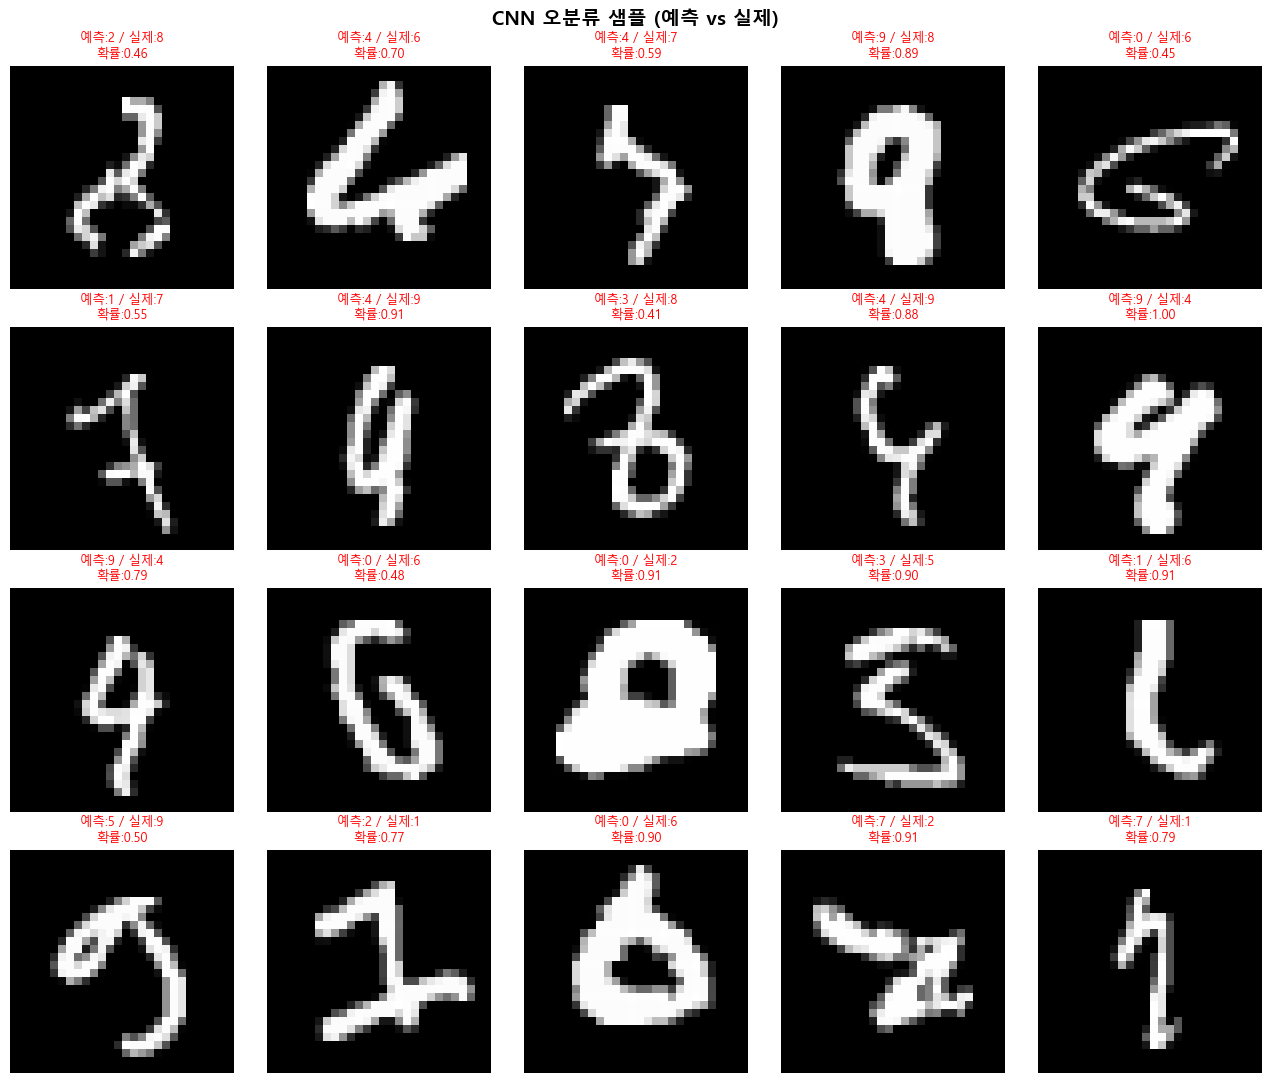

In [25]:
# 8.3 CNN 오분류 샘플 시각화
wrong_mask   = cnn_preds != cnn_targets
wrong_indices = np.where(wrong_mask)[0][:20]

# 테스트 데이터에서 이미지 가져오기
test_images_all = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])

nrows, ncols = 4, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 11))
fig.suptitle('CNN 오분류 샘플 (예측 vs 실제)', fontsize=14, fontweight='bold')

for ax, idx in zip(axes.flatten(), wrong_indices):
    img = test_images_all[idx].squeeze().numpy()
    pred  = cnn_preds[idx]
    true  = cnn_targets[idx]
    conf  = cnn_probs[idx][pred]
    ax.imshow(img, cmap='gray')
    ax.set_title(f'예측:{pred} / 실제:{true}\n확률:{conf:.2f}', fontsize=9,
                 color='red' if pred != true else 'green')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 9. 결과 분석 및 요약

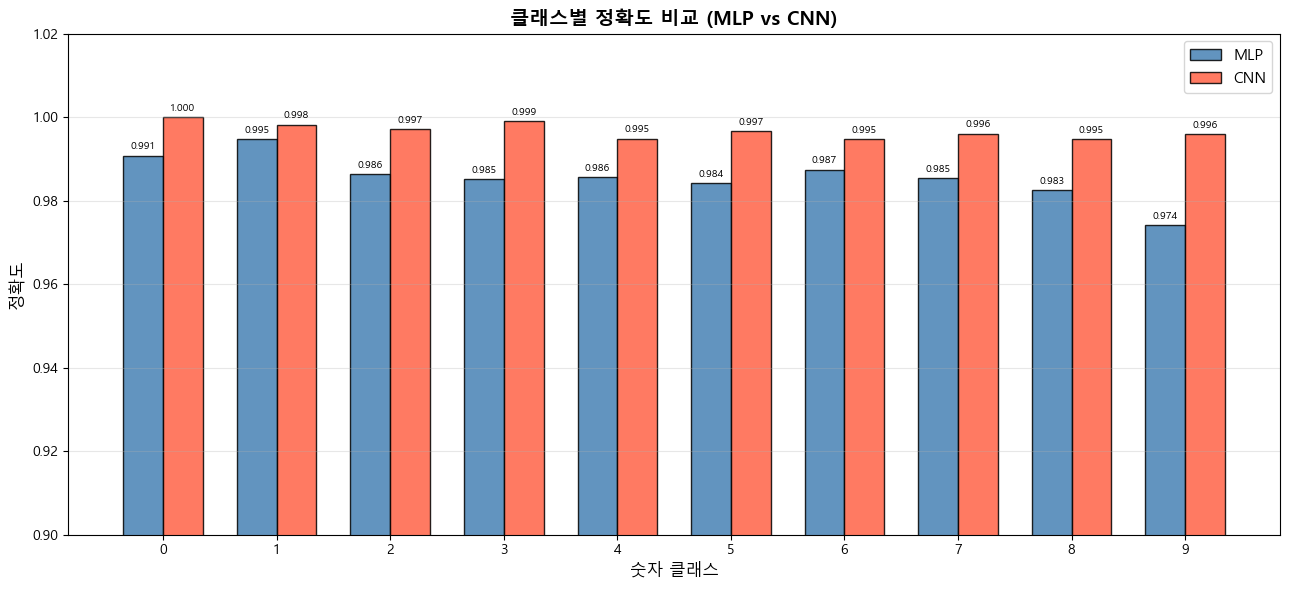

In [26]:
# 클래스별 정확도 비교
mlp_per_class = []
cnn_per_class = []

for digit in range(10):
    mask = mlp_targets == digit
    mlp_per_class.append((mlp_preds[mask] == digit).mean())
    cnn_per_class.append((cnn_preds[mask] == digit).mean())

x = np.arange(10)
width = 0.35

fig, ax = plt.subplots(figsize=(13, 6))
bars1 = ax.bar(x - width/2, mlp_per_class, width, label='MLP', color='steelblue', alpha=0.85, edgecolor='black')
bars2 = ax.bar(x + width/2, cnn_per_class, width, label='CNN', color='tomato',    alpha=0.85, edgecolor='black')

ax.set_xlabel('숫자 클래스', fontsize=12)
ax.set_ylabel('정확도', fontsize=12)
ax.set_title('클래스별 정확도 비교 (MLP vs CNN)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([str(i) for i in range(10)])
ax.set_ylim(0.9, 1.02)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=7.5)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=7.5)

plt.tight_layout()
plt.show()

In [30]:
# 최종 결과 요약
print('=' * 60)
print('              최종 결과 요약')
print('=' * 60)
print(f"{'항목':<20} {'MLP':>15} {'CNN':>15}")
print('-' * 60)
print(f"{'파라미터 수':<20} {count_params(mlp_model):>15,} {count_params(cnn_model):>15,}")
print(f"{'테스트 정확도':<20} {mlp_acc*100:>14.2f}% {cnn_acc*100:>14.2f}%")
print(f"{'최고 검증 acc (에포크)':<20} {max(mlp_history['val_acc'])*100:>14.2f}% {max(cnn_history['val_acc'])*100:>14.2f}%")
print('=' * 60)

winner = 'CNN' if cnn_acc > mlp_acc else 'MLP'
diff   = abs(cnn_acc - mlp_acc) * 100
print(f'\n🏆 최고 성능 모델: {winner} (차이: {diff:.2f}%p)')
print(f'\n분석 요약:')
print('  - MNIST 데이터셋: 70,000개 흑백 손글씨 이미지 (28×28)')
print('  - 10개 클래스 균등 분포 (약 6,000~7,000개/클래스)')
print('  - 전처리: 정규화 + RandomRotation + RandomAffine 증강 적용')
print('  - CNN은 공간적 특징 추출로 MLP보다 높은 성능 달성')
print('  - BatchNorm + Dropout으로 과적합 방지')

              최종 결과 요약
항목                               MLP             CNN
------------------------------------------------------------
파라미터 수                       569,226         871,530
테스트 정확도                       98.58%          99.68%
최고 검증 acc (에포크)               97.38%          99.30%

🏆 최고 성능 모델: CNN (차이: 1.10%p)

분석 요약:
  - MNIST 데이터셋: 70,000개 흑백 손글씨 이미지 (28×28)
  - 10개 클래스 균등 분포 (약 6,000~7,000개/클래스)
  - 전처리: 정규화 + RandomRotation + RandomAffine 증강 적용
  - CNN은 공간적 특징 추출로 MLP보다 높은 성능 달성
  - BatchNorm + Dropout으로 과적합 방지
